In [2]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf

In [3]:
# Lista com as ações da carteira
acoes = ['EMBR3.SA','PETR4.SA','VALE3.SA','BBAS3.SA']

In [4]:
# Criando DF com as cotações usando Adj Close pelo yfinance
#df = pd.DataFrame()
#for i in acoes:
    #df[i] = yf.download(i, start='2021-01-01')['Adj Close']

In [5]:
# Mudando os nomes
#df = df.rename(columns={'EMBR3.SA':'EMBR','PETR4.SA':'PETR','VALE3.SA':'VALE','BBAS3.SA':'BB'})

In [6]:
# Salvando DF para evitar possíveis com yfinance
#df.to_csv('carteira.csv')
df=pd.read_csv('carteira.csv',index_col='Date')

In [7]:
# Descrição estatística dos dados
df.describe()

,EMBR,PETR,VALE,BB
count,851.000000,851.000000,851.000000,851.000000
mean,18.434489,19.979197,69.076433,18.213599
std,5.679503,9.275098,8.026536,5.430428
min,8.370000,7.725775,51.198139,11.193895
25%,14.055000,11.539221,62.725168,13.508345
50%,17.980000,17.481703,66.509026,16.179623
75%,20.800000,26.413382,75.213749,22.937656
max,39.560001,41.669998,88.224312,29.474905


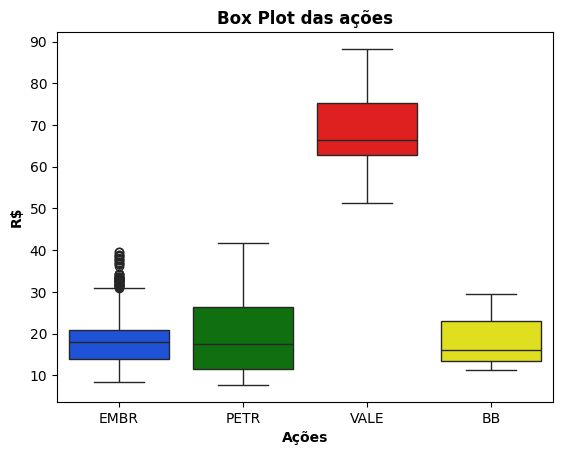

In [8]:
# Criando Box Plot para os papéis
cores=['#0045F5','green','red','yellow']
sns.boxplot(data=df,palette=cores)
plt.title('Box Plot das ações',fontweight='bold')
plt.xlabel('Ações',fontweight='bold')
plt.ylabel('R$',fontweight='bold')
plt.grid(False)
plt.show()

Durante o intervalo de tempo de 2021 até maio de 2024, o gráfico Box Plot e a descrição do df, destacam que a Petrobras e a Vale  tiveram as maiores variações de cotações. Enquanto, os demais tiveram variação mais estáveis e próxima entre si, apesar da Embraer ter tido vários Outliers devido sua alta recente dos preços.  

In [9]:
# Criando gráfico das cotações
figura = px.line(title = 'Histórico de cotações das ações')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df.index, y=df[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

O gráfico demonstra que a Vale ficou "lateralizada" e volátil e as demais é visto uma tendência de crescimento de valor de mercado

In [10]:
# Normalizando as cotações para melhor comparação dos retornos
df_normalizado = df.copy()
for i in df_normalizado.columns[0:]:
  df_normalizado[i] = df_normalizado[i] / df_normalizado[i][0];

/var/folders/f0/r1mlkllj4z14dx7__963964m0000gn/T/ipykernel_1394/1711867627.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [11]:
# Criando gráfico das cotações normalizadas
figura = px.line(title = 'Histórico de cotações das ações (normalizado)')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df_normalizado.index, y=df_normalizado[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

Após a normalização, fica evidente que a maior valorização dos papéis é da Embraer seguida por Petrobras e Banco do Brasil, enquanto, a Vale teve uma pequena queda.

In [12]:
# Criando uma função para calcular a taxa de retorno simples
def txrs(acao,df):
    df[f'RS {acao}'] = (df[f'{acao}'] / df[f'{acao}'].shift(1)) - 1
    return df

In [13]:
# Aplicando a função para todas colunas
for coluna in df.columns[:len(df)]:
    df_txrs = df.copy()
    df_txrs = txrs(coluna, df)

df_txrs= df_txrs.dropna()

In [14]:
df = pd.read_csv('carteira.csv')

In [15]:
def alocacao_ativos(df, capital, seed = 0, melhores_pesos = []):
  df = df.copy()

  if seed != 0:
    np.random.seed(seed)

  if len(melhores_pesos) > 0:
    pesos = melhores_pesos
  else:
    pesos = np.random.random(len(df.columns) - 1)
    pesos = pesos / pesos.sum()

  colunas = df.columns[1:]

  for i in colunas:
    df[i] = (df[i] / df[i][0])

  for i, k in enumerate(df.columns[1:]):
    #print(i, acao)
    df[k] = df[k] * pesos[i] * capital

  df['soma valor'] = df.iloc[:, 1:].sum(axis = 1)

  datas = df['Date']

  df.drop(labels = ['Date'], axis = 1, inplace = True)
  df['taxa retorno'] = 0.0

  for i in range(1, len(df)):
    df['taxa retorno'][i] = ((df['soma valor'][i] / df['soma valor'][i - 1]) - 1) * 100

  acoes_pesos = pd.DataFrame(data = {'Ações': colunas, 'Pesos': pesos * 100})

  return df, datas, acoes_pesos, df.loc[len(df) - 1]['soma valor']

In [16]:
df_original, datas, acoes_pesos, soma_valor = alocacao_ativos(pd.read_csv('carteira.csv'), 5000, 10)

/var/folders/f0/r1mlkllj4z14dx7__963964m0000gn/T/ipykernel_1394/844786342.py:30: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/f0/r1mlkllj4z14dx7__963964m0000gn/T/ipykernel_1394/844786342.py:30: FutureWarning:

ChainedAssignment

In [17]:
import sys

In [18]:
# Criando função de alocação de Markowitz
def alocacao_markowitz(df, capital, i, n):
  df = df.copy()
  df_original = df.copy()

  ls_txe = []
  ls_vole = []
  ls_sr = []

  melhor_sr = 1 - sys.maxsize
  melhores_p = np.empty
  melhor_vol = 0
  melhor_tx = 0

  for _ in range(n):
    pesos = np.random.random(len(df.columns)-1)
    pesos = pesos / pesos.sum()

    for w in df.columns[1:]:
      df[w] = df[w] / df[w][0]

    for w, k in enumerate(df.columns[1:]):
      df[k] = df[k] * pesos[w] * capital

    df.drop(labels = ['Date'], axis = 1, inplace=True)

    retorno_carteira = np.log(df / df.shift(1))
    matriz_cov = retorno_carteira.cov()

    df['soma valor'] = df.sum(axis = 1)
    df['taxa retorno'] = 0.0

    for w in range(1, len(df)):
      df['taxa retorno'][w] = np.log(df['soma valor'][w] / df['soma valor'][w - 1])

    retorno_esperado = np.sum(df['taxa retorno'].mean() * pesos) * 246
    vol_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_cov * 246, pesos)))
    sharpe_ratio = (retorno_esperado - i) / vol_esperada

    if sharpe_ratio > melhor_sr:
      melhor_sr = sharpe_ratio
      melhores_p = pesos
      melhor_vol = vol_esperada
      melhor_tx = retorno_esperado

    ls_txe.append(retorno_esperado)
    ls_vole.append(vol_esperada)
    ls_sr.append(sharpe_ratio)

    df = df_original.copy()

  return melhor_sr, melhores_p, ls_txe, ls_vole, ls_sr, melhor_vol, melhor_tx

In [19]:
# Biblioteca para buscar valores de CDI
#pip install python-bcb
from bcb import sgs

In [20]:
taxa_cdi = sgs.get({'cdi':4389},start='2021-01-01')
media_cdi = float(taxa_cdi.mean() / 100)
media_cdi

/var/folders/f0/r1mlkllj4z14dx7__963964m0000gn/T/ipykernel_1394/1950990518.py:2: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



0.10139498249708287

In [21]:
# Pegando DF limpo
teste = pd.read_csv('carteira.csv')

In [22]:
# Rodando a função
import warnings
warnings.filterwarnings("ignore")
melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_markowitz(teste, 5000, media_cdi, 100);

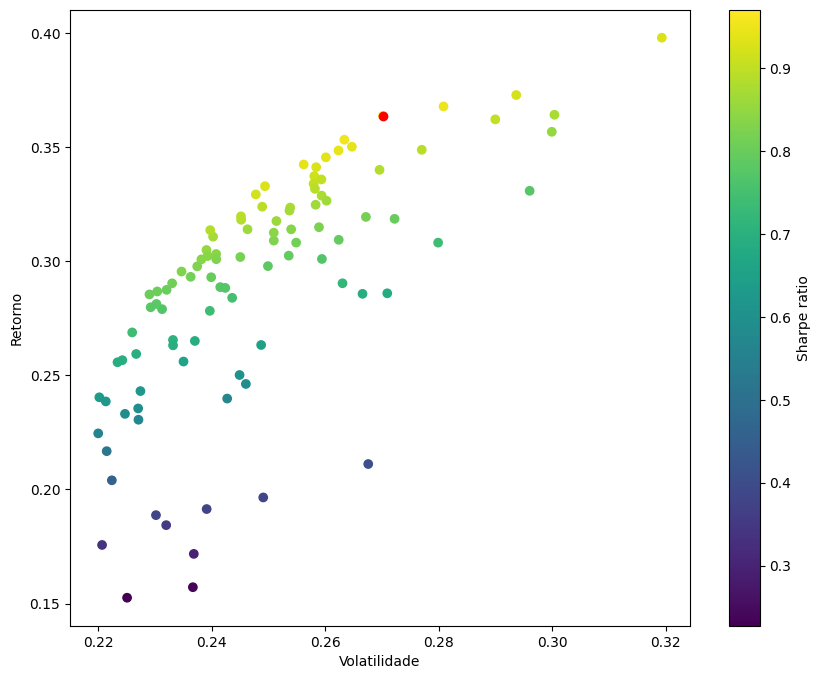

In [23]:
# Gráfico de dispersão
plt.figure(figsize=(10,8))
plt.scatter(lista_volatilidade_esperada, lista_retorno_esperado, c = lista_sharpe_ratio)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red');

In [24]:
# Biblioteca necessária
#pip install https://github.com/gkhayes/mlrose/archive/refs/heads/master.zip

In [25]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [26]:
capital = 10000
df = pd.read_csv('carteira.csv')

In [33]:
def fitness_function(resultado):
  df = pd.read_csv('carteira.csv')
  pesos = resultado / resultado.sum()

  for i in df.columns[1:]:
    df[i] = (df[i] / df[i][0])

  for i, k in enumerate(df.columns[1:]):
    df[k] = df[k] * pesos[i] * capital

  df.drop(labels = ['Date'], axis = 1, inplace=True)
  df['soma valor'] = df.sum(axis = 1)
  df['taxa retorno'] = 0.0

  for i in range(1, len(df)):
    df['taxa retorno'][i] = ((df['soma valor'][i] / df['soma valor'][i - 1]) - 1) * 100

  sharpe_ratio = (df['taxa retorno'].mean() - media_cdi) / df['taxa retorno'].std() * np.sqrt(246)

  return sharpe_ratio

In [34]:
np.random.seed(10)
pesos = np.random.random(len(df.columns) - 1)
pesos = pesos / pesos.sum()
pesos

array([0.35470769, 0.00954321, 0.2913962 , 0.3443529 ])

In [35]:
fitness_function(pesos)

0.21039521628022

In [36]:
def visualiza_carteira(resultado):
  df = pd.read_csv('carteira.csv')
  acoes = df.columns[1:]
  for i in range(len(resultado)):
    print(f'{acoes[i]} tem {resultado[i] * 100:.2f}% da carteira')

In [37]:
visualiza_carteira(pesos)

EMBR tem 35.47% da carteira
PETR tem 0.95% da carteira
VALE tem 29.14% da carteira
BB tem 34.44% da carteira


In [47]:
resultado_fitness = mlrose.CustomFitness(fitness_function)
maximizacao= mlrose.ContinuousOpt(length=len(df.columns)-1,fitness_fn=resultado_fitness,maximize=True, min_val=0,max_val=1)

In [48]:
pesos, melhor_sr = mlrose.hill_climb(maximizacao, random_state = 1)


In [49]:
pesos = pesos / pesos.sum()

In [50]:
visualiza_carteira(pesos)

EMBR tem 63.04% da carteira
PETR tem 36.96% da carteira
VALE tem 0.00% da carteira
BB tem 0.00% da carteira


In [51]:
_, _, _, soma_valor = alocacao_ativos(pd.read_csv('carteira.csv'), 5000, melhores_pesos=pesos)
soma_valor

20850.024309211505

In [52]:
pesos, melhor_sr = mlrose.simulated_annealing(maximizacao, random_state = 1)
pesos = pesos / pesos.sum()

In [53]:
visualiza_carteira(pesos)

EMBR tem 66.67% da carteira
PETR tem 33.33% da carteira
VALE tem 0.00% da carteira
BB tem 0.00% da carteira


In [54]:
_, _, _, soma_valor = alocacao_ativos(pd.read_csv('carteira.csv'), 5000, melhores_pesos=pesos)
soma_valor

21012.667971245413